In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import seaborn as sns
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
%matplotlib inline

In [31]:
Stock = pd.read_csv('/kaggle/input/apple-stock-price-from-19802021/AAPL.csv',  index_col=0)

df_Stock = Stock
df_Stock = df_Stock.rename(columns={'Close(t)':'Close'})
df_Stock.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


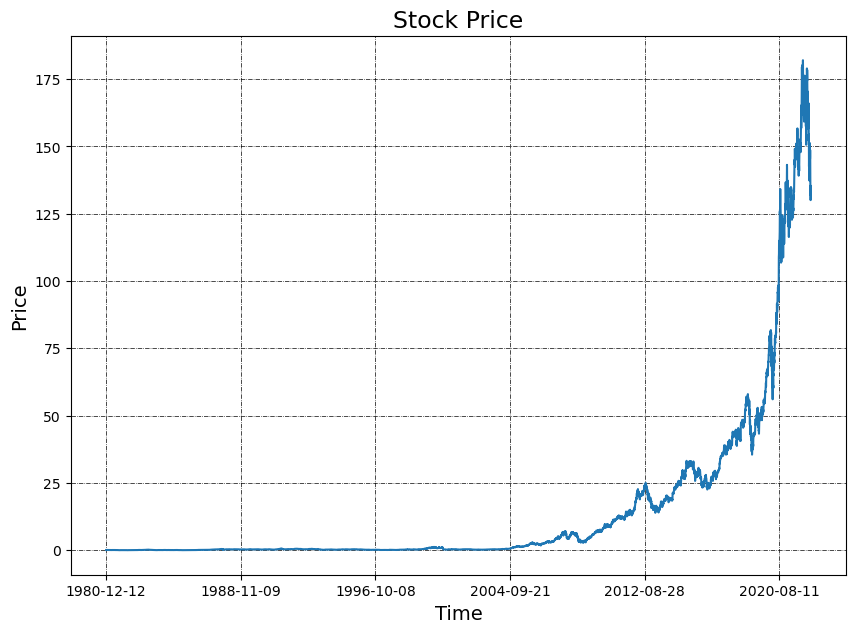

In [32]:
df_Stock['Close'].plot(figsize=(10, 7))
plt.title("Stock Price", fontsize=17)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

**LSTM Prediction**

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math 
import os.path
import keras
from tensorflow.keras.models import model_from_json

In [34]:
df = pd.read_csv('../input/apple-stock-price-from-19802021/AAPL.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600
...,...,...,...,...,...,...
2022-06-13,132.869995,135.199997,131.440002,131.880005,131.880005,122207100
2022-06-14,133.130005,133.889999,131.479996,132.759995,132.759995,84784300
2022-06-15,134.289993,137.339996,132.160004,135.429993,135.429993,91533000


In [35]:
window = 20 # day window

close_prices = df['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

X_train = []
Y_train = []

for i in range(window, len(train_data)):
    X_train.append(train_data[i-window:i, 0])
    Y_train.append(train_data[i, 0])
    
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [36]:
test_data = scaled_data[training_data_len-window: , : ]
X_test = []
Y_test = values[training_data_len:]

for i in range(window, len(test_data)):
    X_test.append(test_data[i-window:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [37]:
train_model = False
if not os.path.exists('model.json') or train_model:
    model = keras.Sequential()
    model.add(layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(layers.LSTM(100, return_sequences=False))
    model.add(layers.Dense(25))
    model.add(layers.Dense(12))
    model.add(layers.Dense(1))
    model.summary()

In [38]:
if not os.path.exists('model.json') or train_model:
    model.compile(optimizer='adam', loss='mean_squared_error')
    with tf.device('/gpu:0'):
        history = model.fit(X_train, Y_train, batch_size= 64, epochs=15)
    # serialize model to JSON
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model.h5")
    print("Saved model to disk")

In [39]:

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [40]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - Y_test)**2)
print("The root mean squared error is {:.2f}".format(rmse))

66/66 [==============================] - 1s 11ms/step
The root mean squared error is 0.79


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



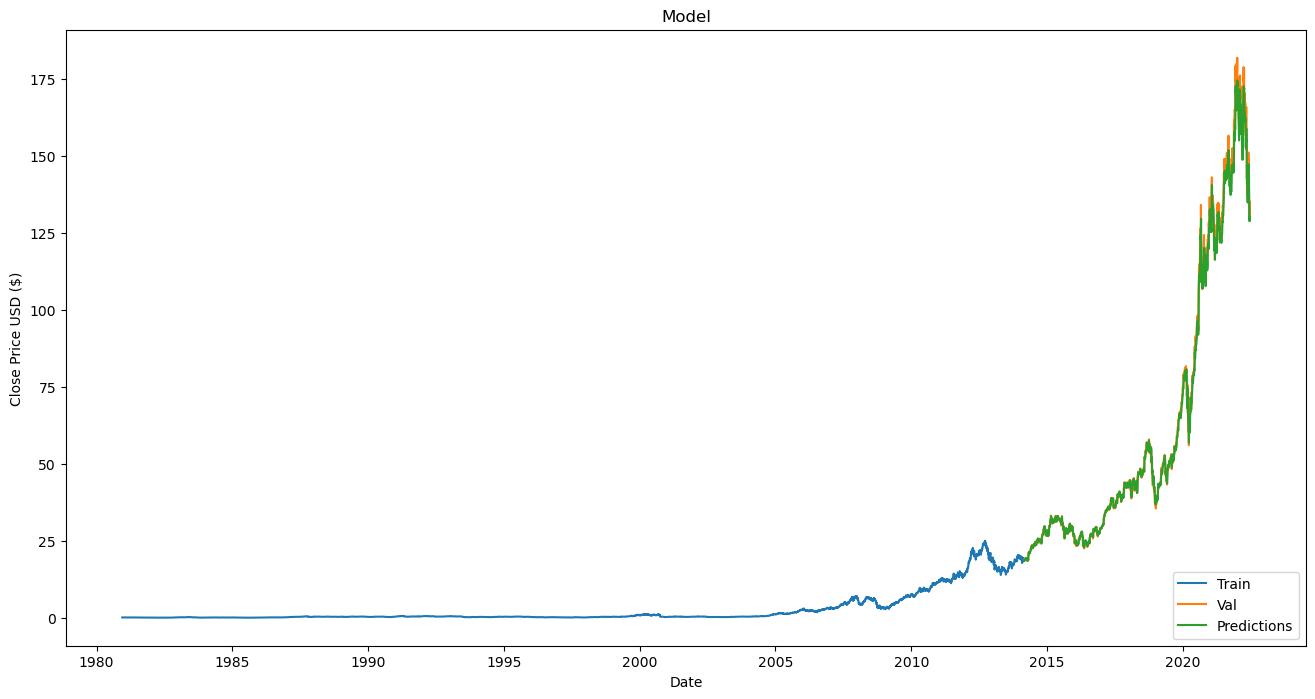

In [41]:
import matplotlib.pyplot as plt

data = df.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [42]:
import plotly.express as px
fig = px.line(validation.reset_index(), x="Date", y=validation.reset_index().columns[1:], title='Predictions vs Actual')
fig.show()